In [3]:
'''Last modified 11.02.2016
    Added mongoDB functionality - one can query any data he wants DESCRIBE HOW TO DO THIS
    Pandas table can be used
09.02.2016
Nothing changed, database and pandas functionality should be added!!!
''';

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# imports

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
# sys.path.append(r'/Users/artemgolovizin/GitHub')
from scipy.optimize import curve_fit
import inspect
import pickle
import imp
import re
import json
import pandas as pd

from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interact, interactive, fixed

import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1

rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
# with dview.sync_imports():
#     import sys, os    
%px import sys, os
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from ipyparallel import bind_kernel; bind_kernel()

import datetime
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId

# start mongoDB client (mongod server should be launched)
client = MongoClient('mongodb://192.168.1.15:27017/')
meas_database = client.measData.meas_data

Done importing, module image_processing now


C:\Program Files\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
# to reload library on remote and local engine
# %px imp.reload(impr)
# imp.reload(impr)
# imp.reload(usfuncs)

In [7]:
# OLD part for getting data from mongoDB
coursor = meas_database.find({'conf_params.SHUTTER':'on','meas_type':'T'})
tables = []
for item in coursor:
    for key in item:
        if(key == 'avr_table_pickle'):
            tables.append(pickle.loads(item[key]))
            print(key,item[key][-20:])
        else:
            print(key,item[key])
    print('\n')

_id 56c4a881f9b7ab11ac20f53f
labels ['time, ms', 'cloud size, $\\mu$ m']
fits [['cloud_expansion0', [19.816501341204766, 152.43184542799173], [0.6413380008178314, 5.739105518065976]], ['cloud_expansion0', [24.139888542898642, 147.838330150716], [0.9166872176748898, 7.933416631048896]]]
date_mod 2016-02-17 20:06:09.161000
conf_params {'F': '363.5/', 'SHUTTER': 'on'}
folder 01 T shutter=on f=363.5/
date_meas 2016-02-17 00:00:00
avr_table_pickle b'K\x0fK\x10K\x01\x87\x94R\x94ueust\x94bub.'
meas_type T


_id 56c4ab72f9b7ab11ac20f541
labels ['time, ms', 'cloud size, $\\mu$ m']
fits [['cloud_expansion0', [11.619547955718934, 331.8274671556903], [0.8787287273173744, 11.945153992281387]], ['cloud_expansion0', [24.010426711234615, 247.78227926514674], [0.38894044870259725, 5.2918034767654785]]]
date_mod 2016-02-17 20:18:42.985000
conf_params {'AMP': '1/', 'F': '363.3', 'SHUTTER': 'on'}
folder 03 T shutter=on f=363.3 amp=1/
date_meas 2016-02-17 00:00:00
avr_table_pickle b'K\x0fK\x10K\x01\x87\x94

In [8]:
mmm = meas_database.find_one()
#print(mmm.keys())

In [9]:
#datetime.datetime(2016, 2, 4, 0, 0) < datetime.datetime(2017, 2, 4, 0, 0)

In [10]:
#mmm['date_meas']

In [11]:
#x = copy(data)

In [12]:
#meas_database.delete_one({'_id': ObjectId('5748820af9b7ab2cb87d49fd')})
#data[61]
#int(data[12]['folder'].split()[0])
#for i in range(0,2):
#meas_database.delete_one({'_id': data[61]['_id']})
#for i in range(0,1):
    #meas_database.delete_one({'_id': data[i]['_id']})

# Перевод x в ту величину, от которой зависимость

In [56]:
powers = dict()
powers = {-9:(4.3-1.5),-8:(6-1.5),-7:(8.5-1.5),-6:13,-5:19,-4:29,-3:44,-2:67,-1:103,0:160,1:250,2:370,3:530,4:750,5:960,6:1180,7:1370,8:1570,9:1680,10:1710}
def sat_param(x, telescope):
    #return array(x), 'dBm at generator'
    return telescope*array([powers[key] for key in x])*1.38/320, 'Параметр насыщения s'
def detuning(x):
    #return 2*(364.7 - array(x)), 'Отстройка, МГц'#/0.35
    return 2*(364.7 - array(x))/0.35, 'Отстройка в единицах'
def B_z(x):
    return 19*array(x)/4, 'Магнитное поле, Гс/см'

# Теоретические зависимости и значения величин

In [14]:
# константы
μB=927.4*10**(-26) # Дж/Тл
hbar=10**(-34) # Дж*с
kB=1.38*10**(-23) # Дж/К
g=10 # m/s

# параметры эксперимента
dB=19*10**(-2)/4*1.5 # Тл/м

# данные тулия
μ=1*μB/hbar
γ=0.350 # MHz
Γ=2*pi*γ # MHz
λ=0.531*10**(-6) # m
k=2*pi/λ
m=169*1.66*10**(-27) # kg

R=hbar*k*Γ*1e6/(2*m*g)

beams=6

def Potential(δ,s,v,z): # проинтегрировано в Математике
    return -10**(-3)*(0.5*hbar*k*Γ*10**6)*(s*pi*γ*10**9/(dB*μ*sqrt(1+s)))*(arctan((-2*pi*λ*δ+2*pi*v*10**(-6)+λ*μ*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s))) - arctan((2*pi*λ*δ+2*pi*v*10**(-6)+λ*μ*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s)))) + 10**(-3)*m*g*z
# коэффициент 10**(-3) из-за того, что z в миллиметрах
def Temperature1(δ,s): # U mode
    return (0.5*hbar*Γ*sqrt(1+beams*s)*1e6/kB)*(0.25*γ*sqrt(1+beams*s)/δ+δ/(γ*sqrt(1+beams*s)))*1e6 # мкК
def Temperature2(δ,s): # V mode
    return (0.5*hbar*Γ*1e6*sqrt(s)/kB)*(0.5*R/sqrt(R-s/s-1/s))*1e6+0*δ # мкК
def Temperature(theory,δ,s):
    if theory==1:
        return (0.5*hbar*Γ*sqrt(1+beams*s)*1e6/kB)*(0.25*γ*sqrt(1+beams*s)/δ+δ/(γ*sqrt(1+beams*s)))*1e6 # мкК # U mode
    if theory==2:
        return (0.5*hbar*Γ*1e6*sqrt(s)/kB)*(0.5*R/sqrt(R-s/s-1/s))*1e6+0*δ # мкК # V mode
def Position(δ,s):
    return 2*pi*1e9*(-δ+0.5*γ*sqrt(R*s-s-1))/(μ*dB) # мм
def PositionGeneral(tmp, δ_set, s_set):
    z = linspace(-5,5,1000) # mm
    y = []
    δ_set = list(flatten([δ_set]))
    s_set = list(flatten([s_set]))
    for δ in δ_set: #tmp[:,0]:
        for s in s_set:
            zmin = z[argmin(1e29*(Potential(-δ,s,0,z)))]
            y.append(zmin)
    return array(y)

# Построение массива зависимостей и построение графиков

In [52]:
def dependency_list(data_local, alt_value, folder_start, folder_end, telescope = 1):
    xx = []
    Tx = []
    Ty = []
    Na = []
    VertPos = []
    σx = [] # mm
    σy = [] # mm
    V = [] # объем
    na = [] # концентрация см^-3
    ρ = [] # фазовая плотность, безразмерная
    τx = [] # оптическая плотность, безразмерная
    τy = [] # оптическая плотность, безразмерная
    for d in data_local:
        folder_number = int(d['folder'].split()[0])
        if  folder_number >= folder_start and folder_number <= folder_end:
            xx.append(float(re.findall(r"[-+]?\d*\.?\d+",d['conf_params'][alt_value])[-1]))
            Tx1 = d['fits'][0][1][0]
            Tx.append(Tx1)
            Ty1 = d['fits'][1][1][0]
            Ty.append(Ty1)
            Na1 = d['avr_table']['fit1D_x']['N'][0]/1e6
            Na.append(Na1)
            VertPos.append(d['avr_table']['fit1D_y']['x0'][0]/1e3) # mm
            σx1 = d['avr_table']['fit1D_x']['sigma'][0]/1e3 # mm
            σx.append(σx1)
            σy1 = d['avr_table']['fit1D_y']['sigma'][0]/1e3 # mm
            σy.append(σy1)
            V1 = pi**1.5 * σy1 * σx1**2
            V.append(V1)
            na1 = Na1*1e9/V1
            na.append(na1)
            λx_dB = 1e5 * hbar * sqrt(2*pi/(m*kB*(Tx1+1))) # cm
            λy_dB = 1e5 * hbar * sqrt(2*pi/(m*kB*Ty1)) # cm
            #na1 = 6.5 * 1e11
            ρ.append(na1 * λy_dB * λx_dB**2)
            τx1 = λ**2 * na1*1e6 * sqrt(pi)*σx1*10**(-3)
            τx.append(τx1)
            τy1 = λ**2 * na1*1e6 * sqrt(pi)*σy1*10**(-3)
            τy.append(τy1)
    
    #subplot(20,2,1)
    #plot(xx, array([powers[key] for key in xx]),'o')
    
    if alt_value == 'F':    # перевод xx в отстройку
        xx, x_lbl = detuning(xx)
    if alt_value == 'A':    # перевод xx в параметр насыщения
        xx, x_lbl = sat_param(xx, telescope)
    if alt_value == 'AH':   # перевод xx в магнитное поле
        xx, x_lbl = B_z(xx)
    
    # упорядочим массивы в соответствии с массивом xx
    indexes_for_sort = []
    indexes_for_sort = argsort(xx)
    Tx = array(Tx)[indexes_for_sort]
    Ty = array(Ty)[indexes_for_sort]
    Na = array(Na)[indexes_for_sort]
    VertPos = array(VertPos)[indexes_for_sort]
    VertPos = min(VertPos) - VertPos
    σx = array(σx)[indexes_for_sort]
    σy = array(σy)[indexes_for_sort]
    na = array(na)[indexes_for_sort]
    ρ = array(ρ)[indexes_for_sort]
    τx = array(τx)[indexes_for_sort]
    τy = array(τy)[indexes_for_sort]
    xx = xx[indexes_for_sort]
    
    return array(list(zip(xx,Tx,Ty,Na,VertPos,σx,σy,na,ρ,τx,τy))), x_lbl

def drawing(tmp, x_lbl, k, graph_name, mset, columns=1): 
# tmp - массив данных, x_lbl - подпись оси x, k - номер серии графиков, graph_name - название графика, mset - массив маркеров для графика (не менее 3 штук)
    nop = 20 # number of plots
    figsize(15,5*nop)
    nodp = 10

    j=0
    if columns == 2 and k == 2:
        k=1
        j=1
    
    subplot(nop,2,(k-1)*nodp+1+j)
    plot(tmp[:,0],tmp[:,1],mset[0], label='T гориз')
    xlabel(x_lbl, fontsize=24, family="verdana")
    ylabel('Температура, мкК', fontsize=24, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    subplot(nop,2,(k-1)*nodp+1+columns+j)
    plot(tmp[:,0],tmp[:,2],mset[1], label='T верт')
    xlabel(x_lbl, fontsize=24, family="verdana")
    ylabel('Температура, мкК', fontsize=24, family="verdana")
    #title(graph_name, fontsize=24, family="verdana")
    subplot(nop,2,(k-1)*nodp+1+2*columns+j)
    plot(tmp[:,0],tmp[:,1],mset[0], label='T horiz')
    plot(tmp[:,0],tmp[:,2],mset[1], label='T vert')
    xlabel(x_lbl, fontsize=24, family="verdana")
    ylabel('Температура, мкК', fontsize=24, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    legend()
    
    subplot(nop,2,(k-1)*nodp+1+3*columns+j)
    plot(tmp[:,0],tmp[:,3],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Число атомов 10^6', fontsize=14, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+1+4*columns+j)
    plot(tmp[:,0],tmp[:,4],mset[2])
    xlabel(x_lbl, fontsize=24, family="verdana")
    ylabel('Положение, мм', fontsize=24, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+1+5*columns+j)
    plot(tmp[:,0],tmp[:,5],mset[0])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Размер, мм', fontsize=14, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    subplot(nop,2,(k-1)*nodp+1+5*columns+j)
    plot(tmp[:,0],tmp[:,6],mset[1])
    xlabel(x_lbl, fontsize=14, family="verdana")
    #ylabel('Вертикальный размер, мм', fontsize=14, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+1+6*columns+j)
    plot(tmp[:,0],tmp[:,7],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Концентрация, см^-3', fontsize=14, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+1+7*columns+j)
    plot(tmp[:,0],tmp[:,8],mset[2])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Фазовая плотность', fontsize=14, family="verdana")
    #title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+1+8*columns+j)
    plot(tmp[:,0],tmp[:,9],mset[0])
    xlabel(x_lbl, fontsize=14, family="verdana")
    ylabel('Оптическая плотность', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
    subplot(nop,2,(k-1)*nodp+1+8*columns+j)
    plot(tmp[:,0],tmp[:,10],mset[1])
    xlabel(x_lbl, fontsize=14, family="verdana")
    #ylabel('Оптическая плотность, мм', fontsize=14, family="verdana")
    title(graph_name, fontsize=14, family="verdana")
    
def drawing_theory(tmp, param, alt_value, k, theory, mset, columns=1):
# tmp - массив данных, k - номер серии графиков, param - параметр насыщения или отстройка, theory - 1 или 2, mset - массив маркеров для графика (не менее 3 штук)
    nop = 20 # number of plots
    figsize(15,5*nop)
    nodp = 10
    
    j=0
    if columns == 2 and k == 2:
        k=1
        j=1
    
    scan = linspace(0.01,10*max(tmp[:,0]),10000)
    if alt_value == 'F':
        δ = scan
        s = param
    if alt_value == 'A':
        s = scan
        δ = param
    δ=δ*0.35
    
    subplot(nop,2,(k-1)*nodp+1+j)
    plot(scan,Temperature(theory,δ,s),mset[0])
    axis([0,max(tmp[:,0])+0.5,0,max(max(tmp[:,1]),max(tmp[:,2]))+5])
    
    subplot(nop,2,(k-1)*nodp+1+columns+j)
    plot(scan,Temperature(theory,δ,s),mset[0])
    axis([0,max(tmp[:,0])+0.5,0,max(max(tmp[:,1]),max(tmp[:,2]))+5])
    
    subplot(nop,2,(k-1)*nodp+1+2*columns+j)
    plot(scan,Temperature(theory,δ,s),mset[0])
    axis([0,max(tmp[:,0])+0.5,0,max(max(tmp[:,1]),max(tmp[:,2]))+5])
    
    if alt_value == 'F':
        scan = linspace(0.1,10*max(tmp[:,0]),10000)
        δ = scan
        s = param
    
    subplot(nop,2,(k-1)*nodp+1+4*columns+j)
    #plot(scan,Position(δ,s),mset[0])
    plot(scan,PositionGeneral(tmp,δ,s),mset[0])
    axis([0,max(tmp[:,0])+0.5,min(tmp[:,4])-0.1,0.1])

# 2016_05_27 От мощности при 364.2 и 364.6

In [16]:
#data[19]

[ 0.0301875  0.0560625  0.0560625  0.0560625  0.0819375  0.1250625  0.18975
  0.2889375  0.4441875  0.69       1.078125   1.595625   2.285625   3.234375
  4.14       5.08875    5.908125   6.770625   7.245      7.374375   7.374375 ]


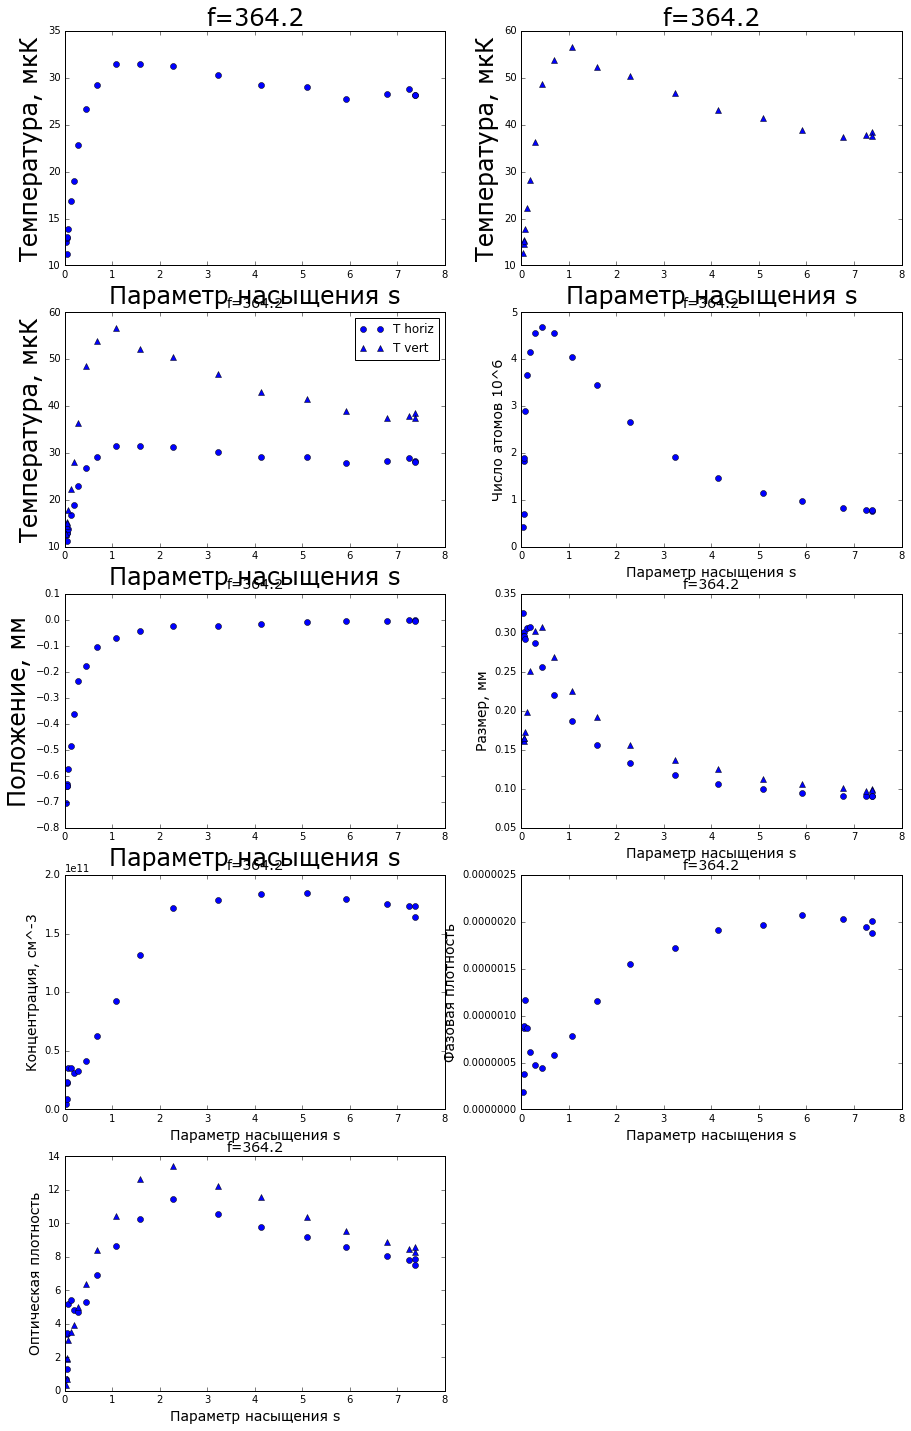

In [34]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 27, 0, 0), 'meas_type':'T'})#, 'conf_params.F': '364.2' 
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')

# от мощности с телескопом (как обычно), f=364.6
tmp, x_lbl = dependency_list(data, 'A', 30, 46)

#drawing(tmp, x_lbl, 1, 'f=364.6', ['go', 'g^', 'go'])
δ = 0.2
#drawing_theory(tmp, δ, 'A', 1, 1, ['g-'])
#drawing_theory(tmp, δ, 'A', 1, 2, ['g--'])

vs_P_2016_05_27_small_detuning = tmp, x_lbl
    
# от мощности с телескопом (как обычно), f=364.2
tmp, x_lbl = dependency_list(data, 'A', 9, 29)

drawing(tmp, x_lbl, 1, 'f=364.2', ['bo', 'b^', 'bo'])
δ = 1.0
#drawing_theory(tmp, δ, 'A', 1, 1, ['b-'])
#drawing_theory(tmp, δ, 'A', 1, 2, ['b--'])

vs_P_2016_05_27 = tmp, x_lbl

print(tmp[:,0])

# 2016_05_05 От мощности при 363.5

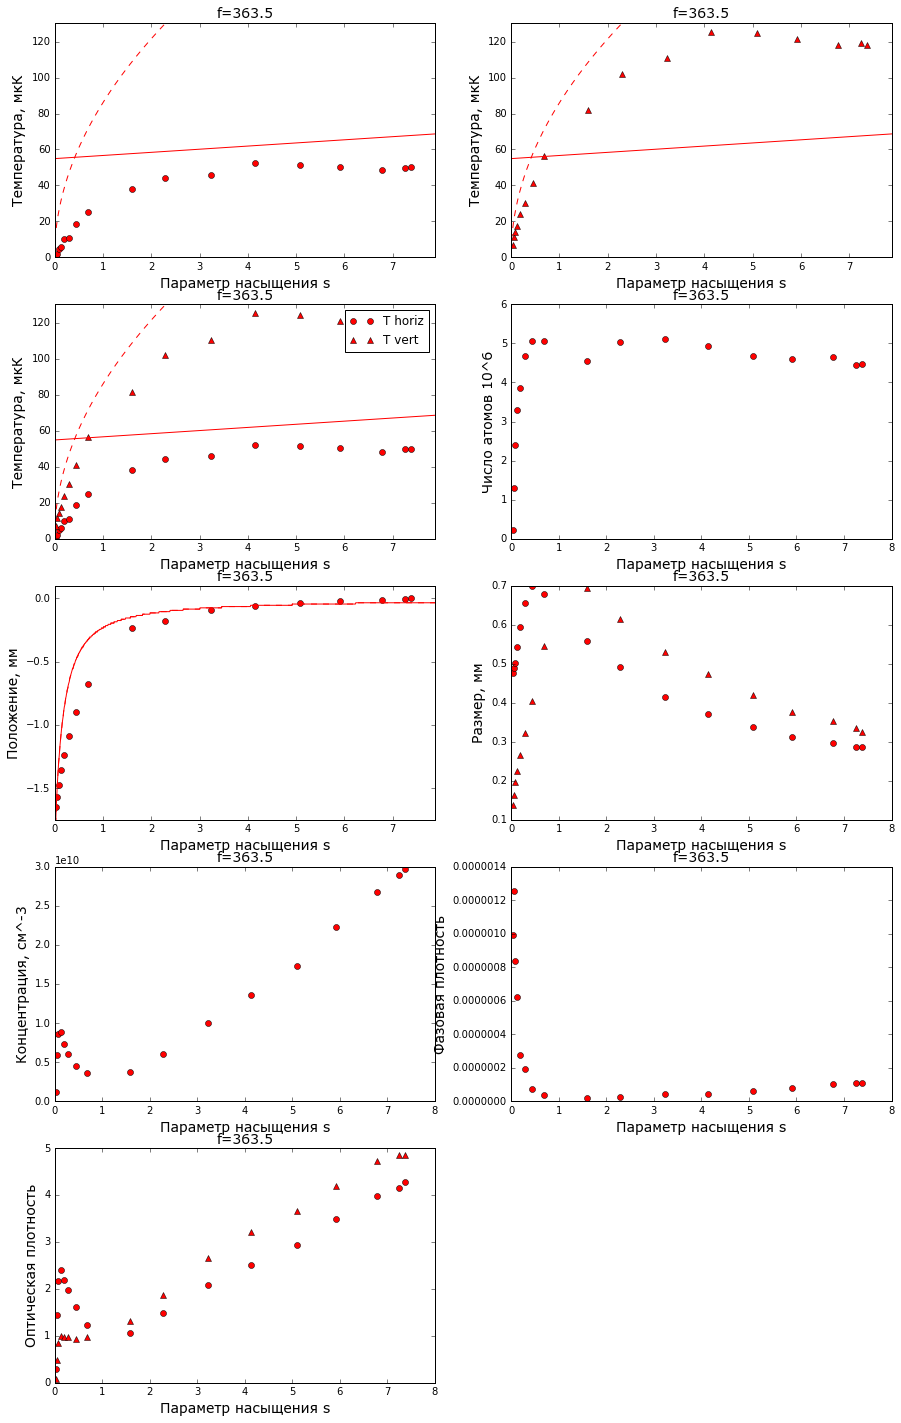

In [18]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 5, 0, 0), 'meas_type':'T', 'conf_params.F': '363.5' })
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')


    
# от мощности с телескопом (как обычно)
tmp, x_lbl = dependency_list(data, 'A', 8, 25)

#print(tmp)
tmp = np.delete(tmp,8,axis=0)
#print(tmp)

drawing(tmp, x_lbl, 1, 'f=363.5', ['ro', 'r^', 'ro'])

δ = 2.4
drawing_theory(tmp, δ, 'A', 1, 1, ['r-'])
drawing_theory(tmp, δ, 'A', 1, 2, ['r--'])

vs_P_2016_05_05 = tmp, x_lbl

#print(data[0]['avr_table']['fit1D_y'])
#help(plot)

# 2016_05_06 От мощности при 363.5 без телескопа

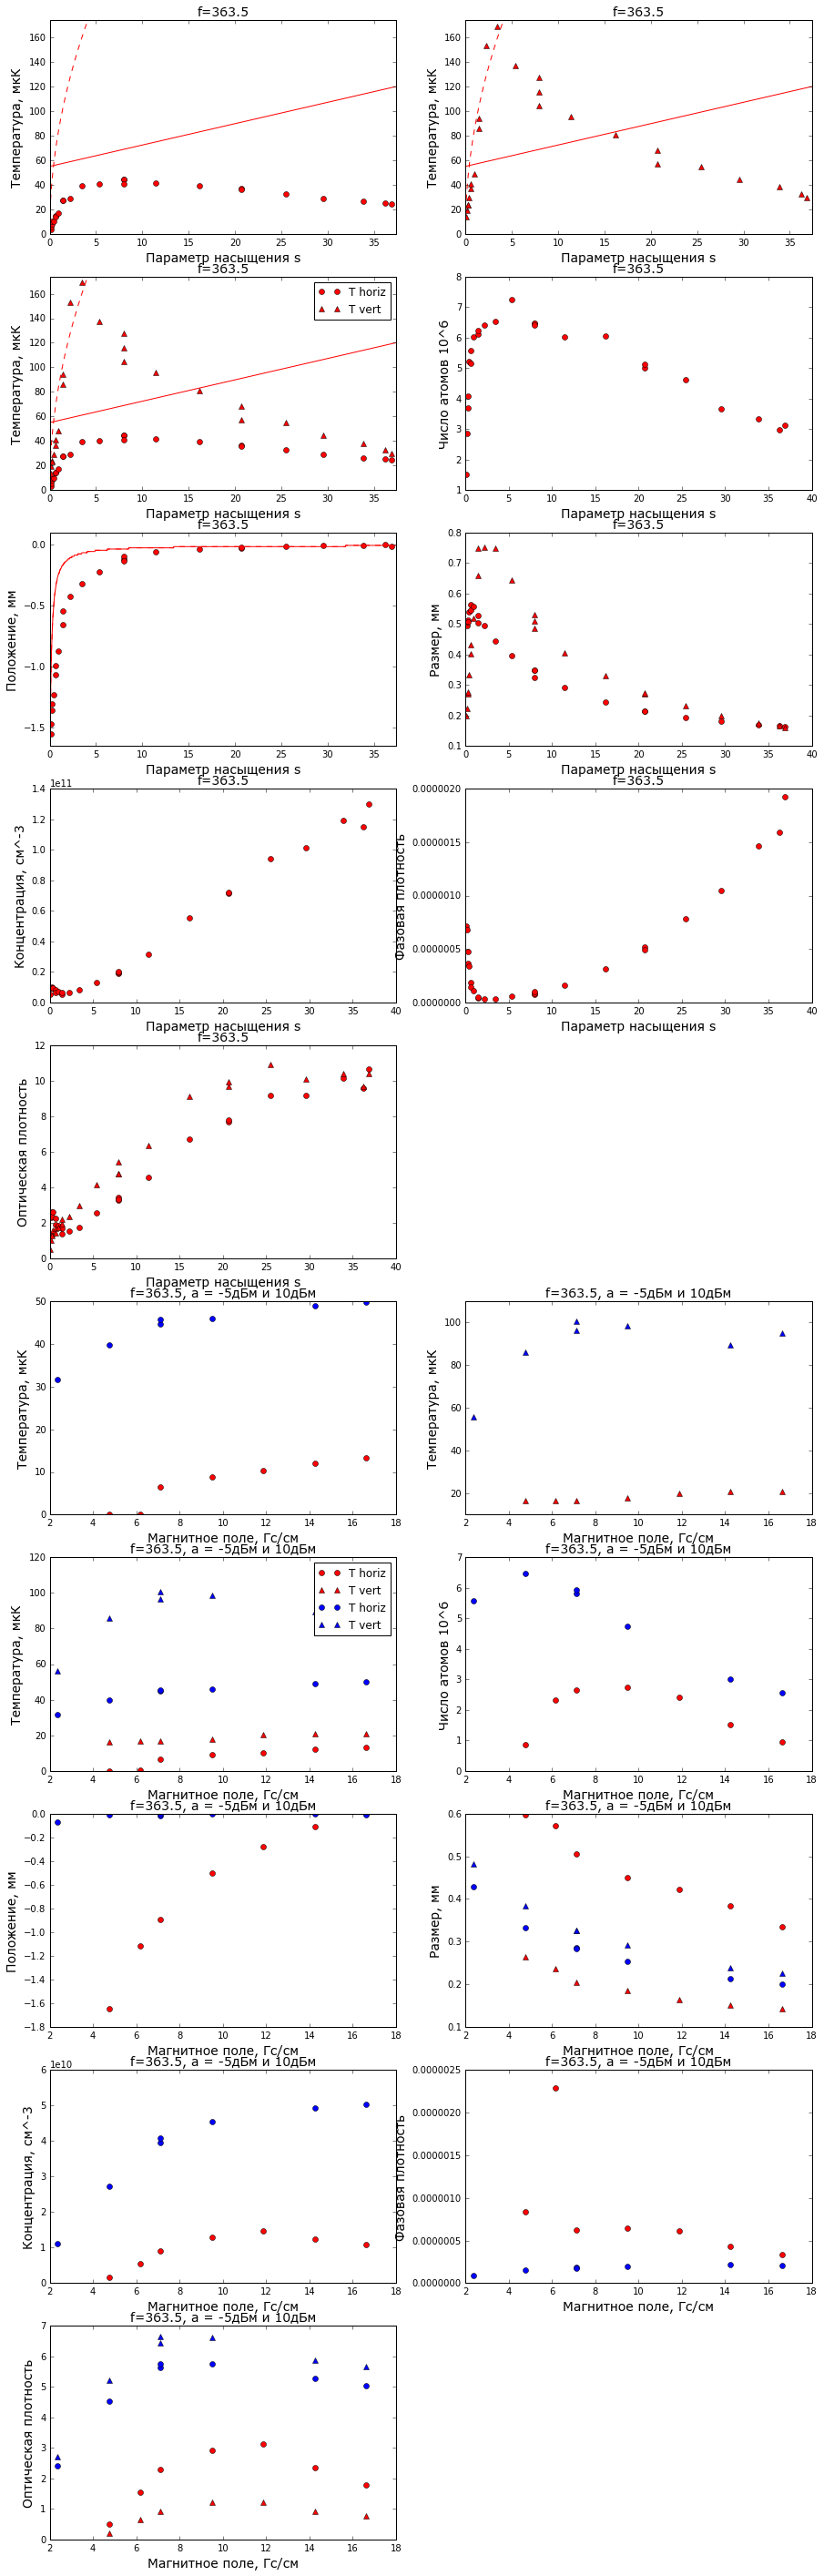

In [19]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 6, 0, 0), 'meas_type':'T', 'conf_params.F': '363.5' })
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')



# от мощности без телескопа

tmp, x_lbl = dependency_list(data, 'A', 52, 77, telescope = 4*1.25)

#print(tmp)
tmp = np.delete(tmp,11,axis=0)

drawing(tmp, x_lbl, 1, 'f=363.5', ['ro', 'r^', 'ro'])
δ = 2.4
drawing_theory(tmp, δ, 'A', 1, 1, ['r-'])
drawing_theory(tmp, δ, 'A', 1, 2, ['r--'])

vs_P_wt_2016_05_06 = tmp, x_lbl

# от магнитного поля, -5 дБм, с телескопом (как обычно)

tmp, x_lbl = dependency_list(data, 'AH', 37, 43)

drawing(tmp, x_lbl, 2, 'f=363.5, a = -5дБм и 10дБм', ['ro', 'r^', 'ro'])

# от магнитного поля, 10 дБм, с телескопом (как обычно)

tmp, x_lbl = dependency_list(data, 'AH', 44, 51)

drawing(tmp, x_lbl, 2, 'f=363.5, a = -5дБм и 10дБм', ['bo', 'b^', 'bo'])

# 2016_05_07 От отстройки при 10 дБм, s=7,4

1.17377263024


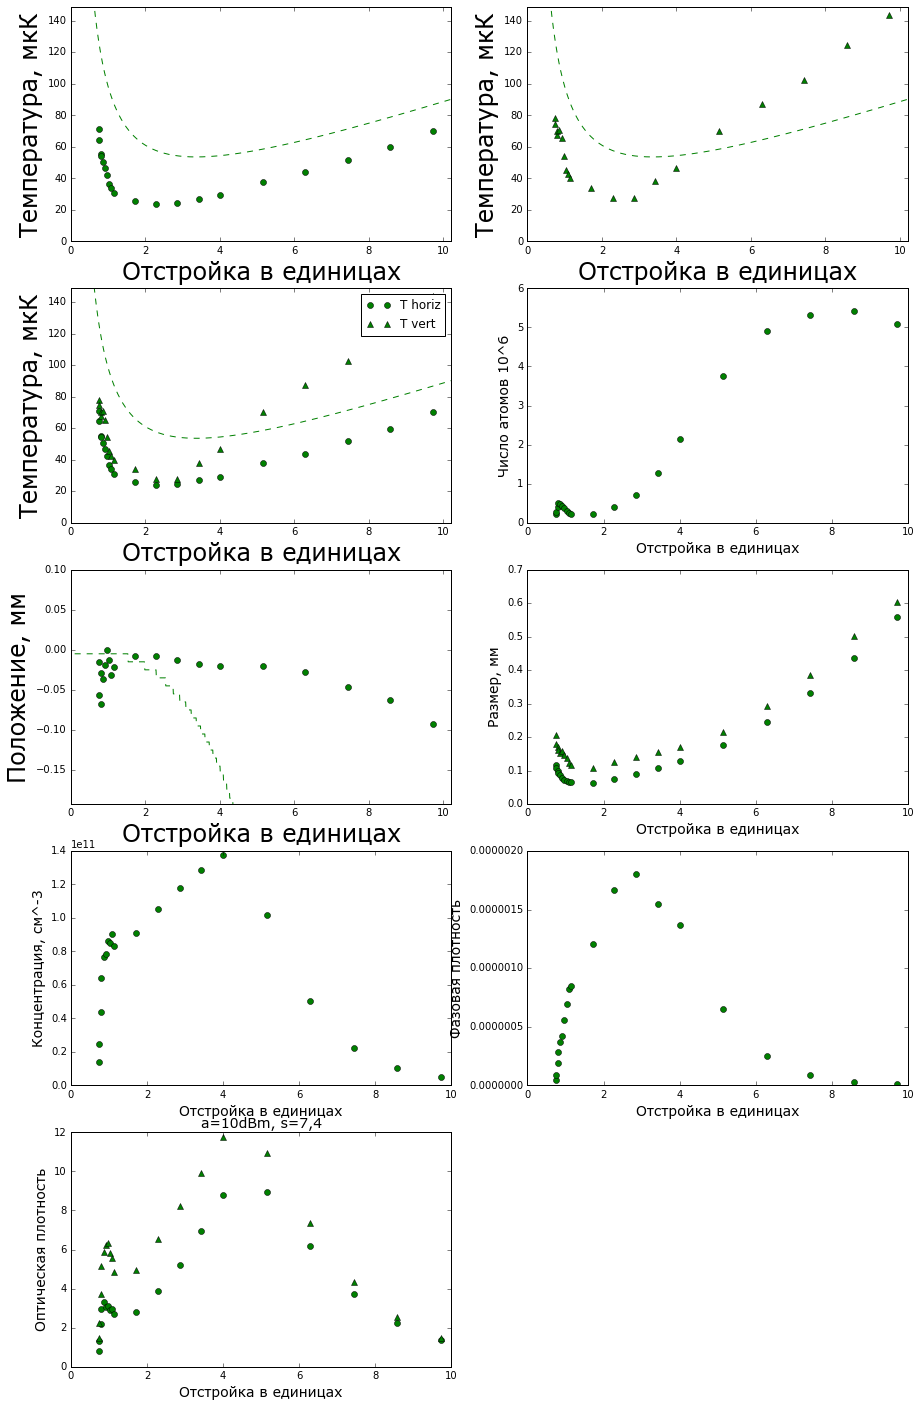

In [57]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 7, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')



# от отстройки
tmp, x_lbl = dependency_list(data, 'F', 1, 21)

tmp = np.delete(tmp,20,axis=0)

drawing(tmp, x_lbl, 1, 'a=10dBm, s=7,4', ['go', 'g^', 'go'])

s = powers[10]*1.38/320
drawing_theory(tmp, s, 'F', 1, 1, ['g--'])

#title('a=%idBm'%nop, fontsize=14, family="verdana")

vs_D_2016_05_07 = tmp, x_lbl

print(0.35*sqrt(1+6*1.7*1.38/0.32)/2)

# 2016_05_08  От отстройки при -5 дБм, s=0,08

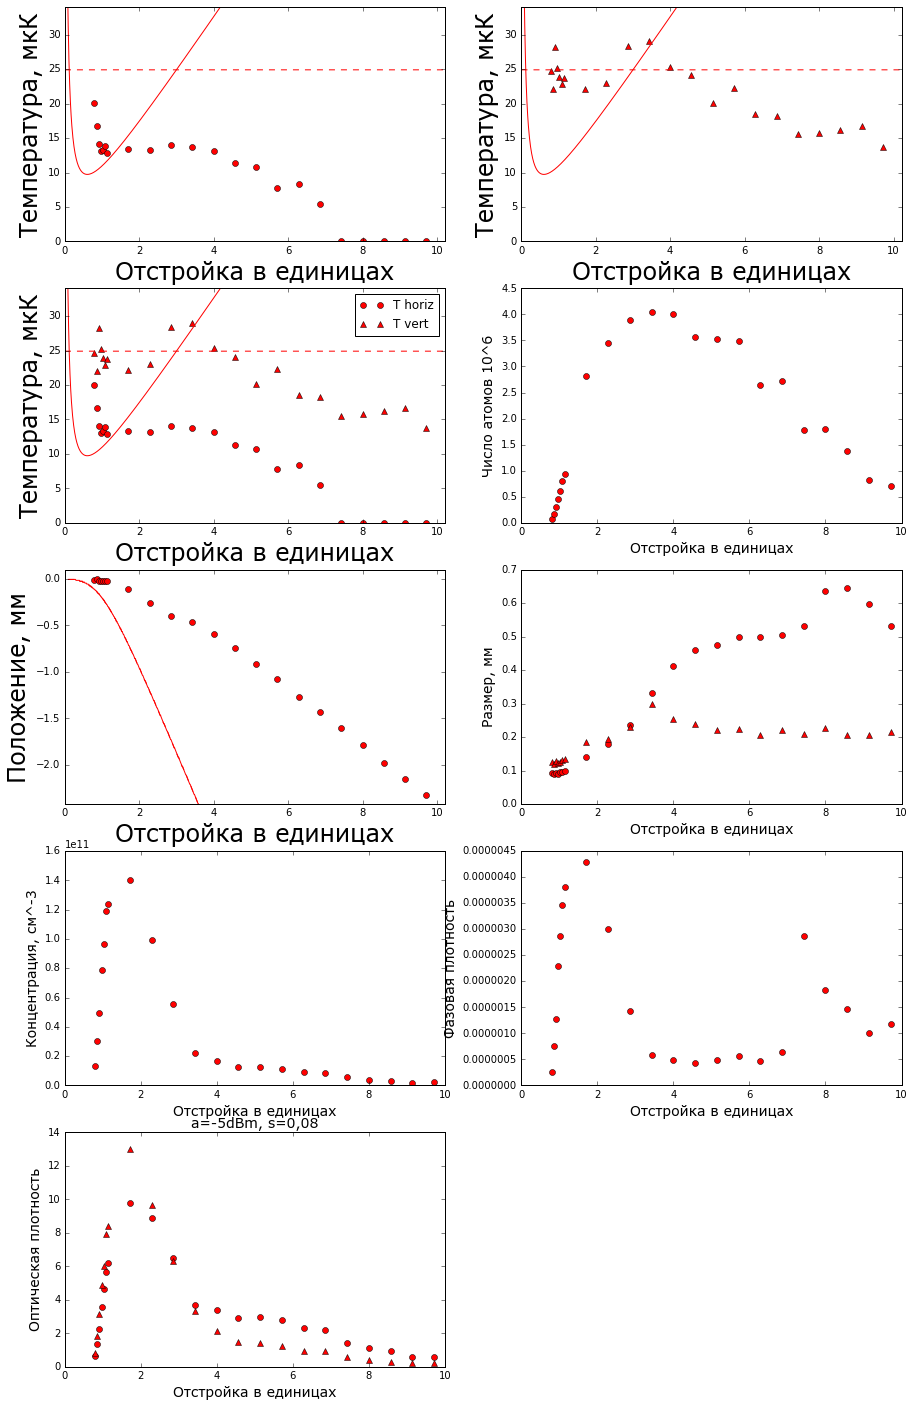

In [58]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 8, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')



# от отстройки
tmp, x_lbl = dependency_list(data, 'F', 1, 25)

drawing(tmp, x_lbl, 1, 'a=-5dBm, s=0,08', ['ro', 'r^', 'ro'])

s = powers[-5]*1.38/320
drawing_theory(tmp, s, 'F', 1, 1, ['r-'])
drawing_theory(tmp, s, 'F', 1, 2, ['r--'])

vs_D_2016_05_08 = tmp, x_lbl

# 2016_05_11 От мощности при 363.5 с перевернутым телескопом

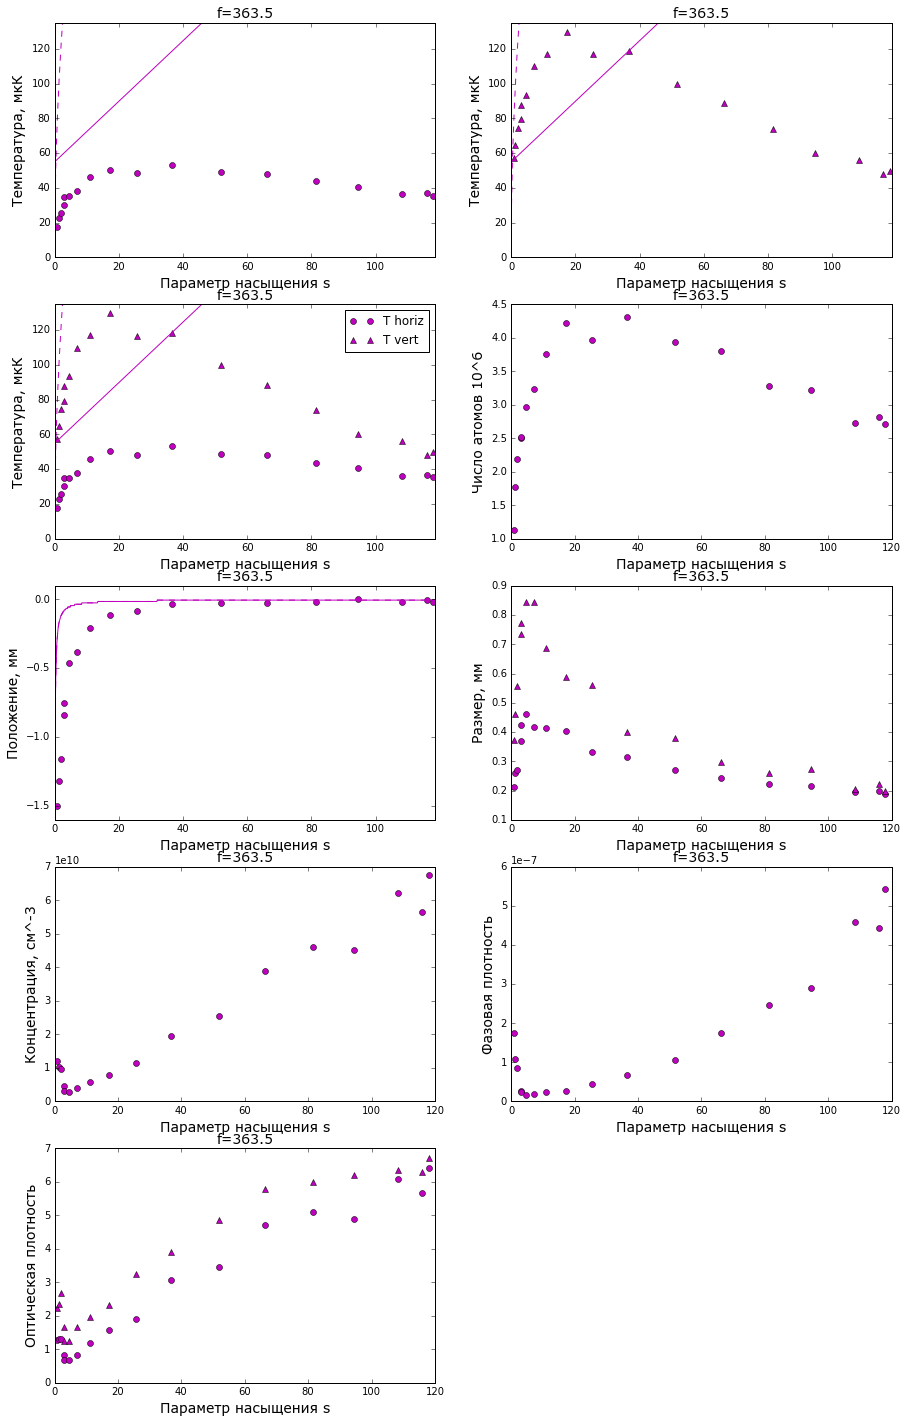

In [22]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 11, 0, 0), 'meas_type':'T'})#, 'conf_params.F': '363.5' 
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 5, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')
    

# от мощности с перевернутым телескопом
tmp, x_lbl = dependency_list(data, 'A', 17, 34, telescope = 4*4) #/6

drawing(tmp, x_lbl, 1, 'f=363.5', ['mo', 'm^', 'mo'])
δ = 2.4
drawing_theory(tmp, δ, 'A', 1, 1, ['m-'])
drawing_theory(tmp, δ, 'A', 1, 2, ['m--'])

vs_P_wrt_2016_05_11 = tmp, x_lbl

# 2016_05_12  От отстройки при 10 дБм и 5 дБм без телескопа, s=37 и s=21

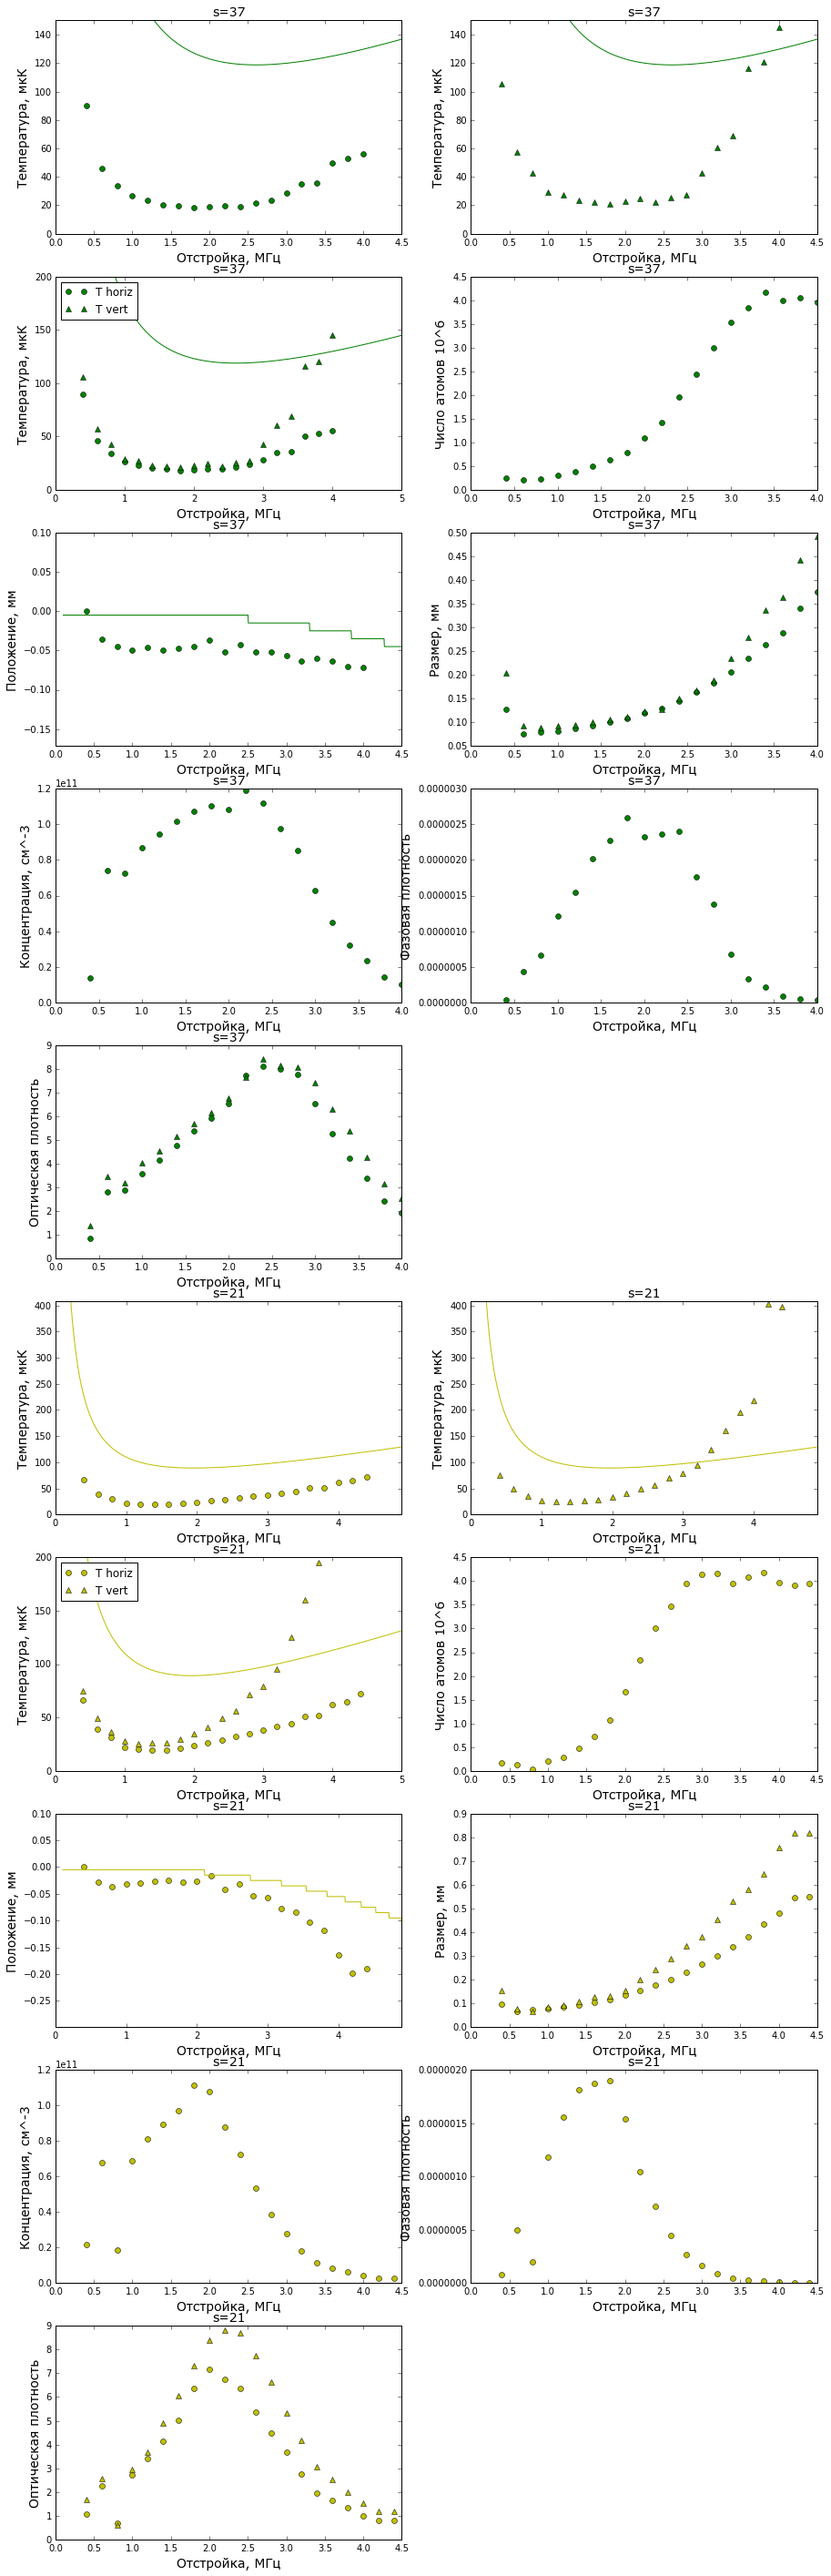

In [23]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })
# , 'conf_params.A': { '$in': ['0dBm','0dBm/'] }

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')

    

# от отстройки

tmp, x_lbl = dependency_list(data, 'F', 1, 19, telescope = 1.25*4)

drawing(tmp, x_lbl, 1, 's=37', ['go', 'g^', 'go'])#a=10dBm wt, 

s = 1.25*4*powers[10]*1.38/320
drawing_theory(tmp, s, 'F', 1, 1, ['g-'])
subplot(20,2,3)
legend(loc=2)
axis([0,5,0,200])

vs_D_10wt_2016_05_12 = tmp, x_lbl

#telescope = 1
tmp, x_lbl = dependency_list(data, 'F', 20, 40, telescope = 1.25*4)

drawing(tmp, x_lbl, 2, 's=21', ['yo', 'y^', 'yo'])#a=5dBm wt, 

s = 1.25*4*powers[5]*1.38/320
drawing_theory(tmp, s, 'F', 2, 1, ['y-'])
subplot(20,2,13)
legend(loc=2)
axis([0,5,0,200])

vs_D_5wt_2016_05_12 = tmp, x_lbl

# 2015_07_01 От отстройки при -2,-1,0,1,2 дБм, s=0.47,0.32,0.2,0.13,0.09

ValueError: num must be 1 <= num <= 40, not 41

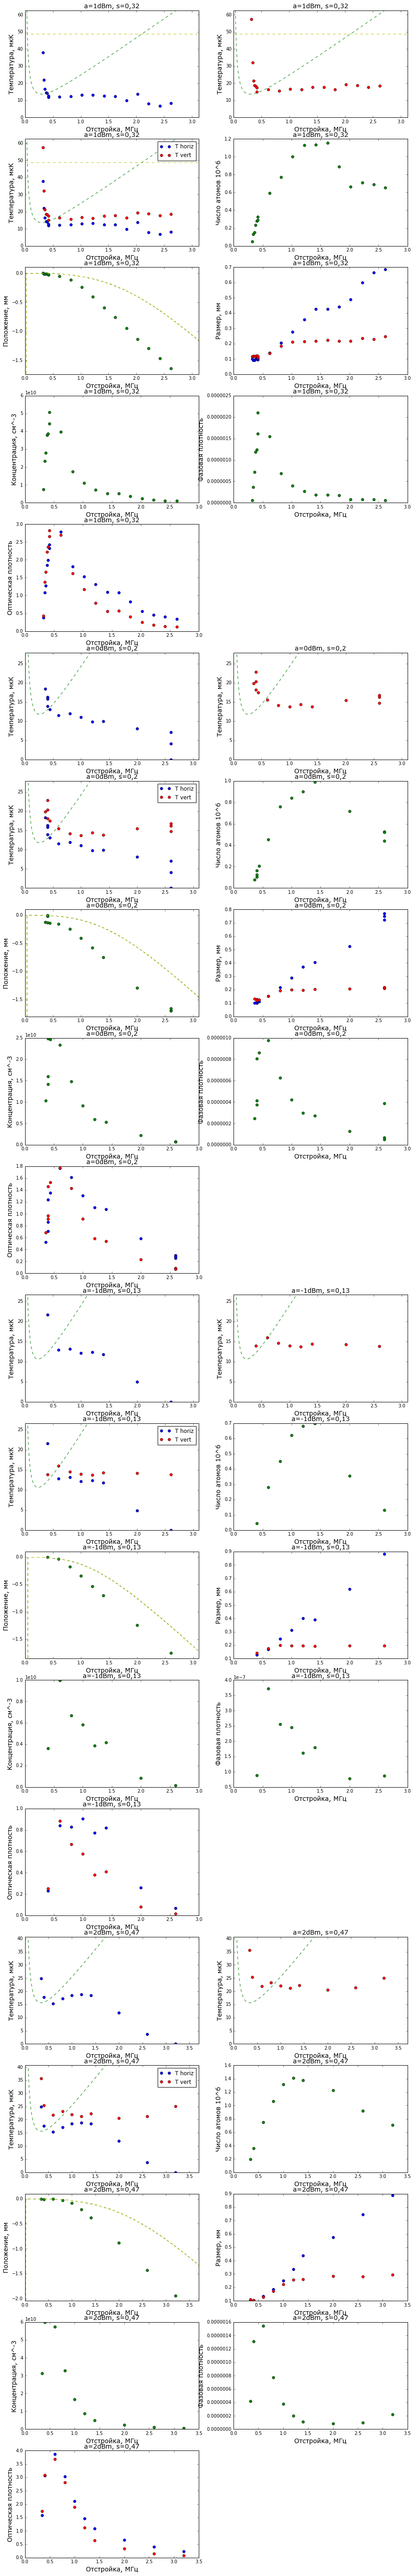

In [495]:
# get data from mongo db and print folders names and dates
coursor = meas_database.find()
coursor = meas_database.find({'date_meas':datetime.datetime(2015, 7, 1, 0, 0), 'meas_type':'T'})
#coursor = meas_database.find({'date_meas':datetime.datetime(2016, 5, 12, 0, 0), 'meas_type':'T', 'conf_params.A': { '$in': ['6dBm','6dBm/'] } })

data = []
for item in coursor:
    data.append(item.copy())
    data[-1]['avr_table'] = pickle.loads(item['avr_table_pickle'])
    del data[-1]['avr_table_pickle']
    #print(len(data)-1, 'date=',data[-1]['date_meas'].date(), 'folder=',data[-1]['folder'])
    #print('\n')

#tmp, x_lbl = vs_D_2016_05_08
#drawing(tmp, x_lbl, 1, 'a=-5dBm, s=0,08', ['ro', 'r^', 'ro'])    
    
# от отстройки
tmp, x_lbl = dependency_list(data, 'F', 1, 18)
drawing(tmp, x_lbl, 1, 'a=1dBm, s=0,32', ['bo', 'ro', 'go'])
s = 74*1.38/320
drawing_theory(tmp, s, 'F', 1, 1, ['g--'])
drawing_theory(tmp, s, 'F', 1, 2, ['y--'])
#print(s)

vs_D_74_2015_07_01 = tmp, x_lbl

tmp, x_lbl = dependency_list(data, 'F', 19, 33)

drawing(tmp, x_lbl, 2, 'a=0dBm, s=0,2', ['bo', 'ro', 'go'])
s = 46*1.38/320
drawing_theory(tmp, s, 'F', 2, 1, ['g--'])
drawing_theory(tmp, s, 'F', 2, 2, ['y--'])
#print(s)

vs_D_46_2015_07_01 = tmp, x_lbl

tmp, x_lbl = dependency_list(data, 'F', 34, 41)

drawing(tmp, x_lbl, 3, 'a=-1dBm, s=0,13', ['bo', 'ro', 'go'])
s = 30*1.38/320
drawing_theory(tmp, s, 'F', 3, 1, ['g--'])
drawing_theory(tmp, s, 'F', 3, 2, ['y--'])
#print(s)

vs_D_30_2015_07_01 = tmp, x_lbl

tmp, x_lbl = dependency_list(data, 'F', 42, 51)

drawing(tmp, x_lbl, 4, 'a=2dBm, s=0,47', ['bo', 'ro', 'go'])
s = 110*1.38/320
drawing_theory(tmp, s, 'F', 4, 1, ['g--'])
drawing_theory(tmp, s, 'F', 4, 2, ['y--'])
#print(s)

vs_D_110_2015_07_01 = tmp, x_lbl

tmp, x_lbl = dependency_list(data, 'F', 52, 58)

drawing(tmp, x_lbl, 5, 'a=-2dBm, s=0,09', ['bo', 'ro', 'go'])
s = 20*1.38/320
drawing_theory(tmp, s, 'F', 5, 1, ['g--'])
drawing_theory(tmp, s, 'F', 5, 2, ['y--'])
#print(s)

vs_D_20_2015_07_01 = tmp, x_lbl

# Итоговый график от мощности

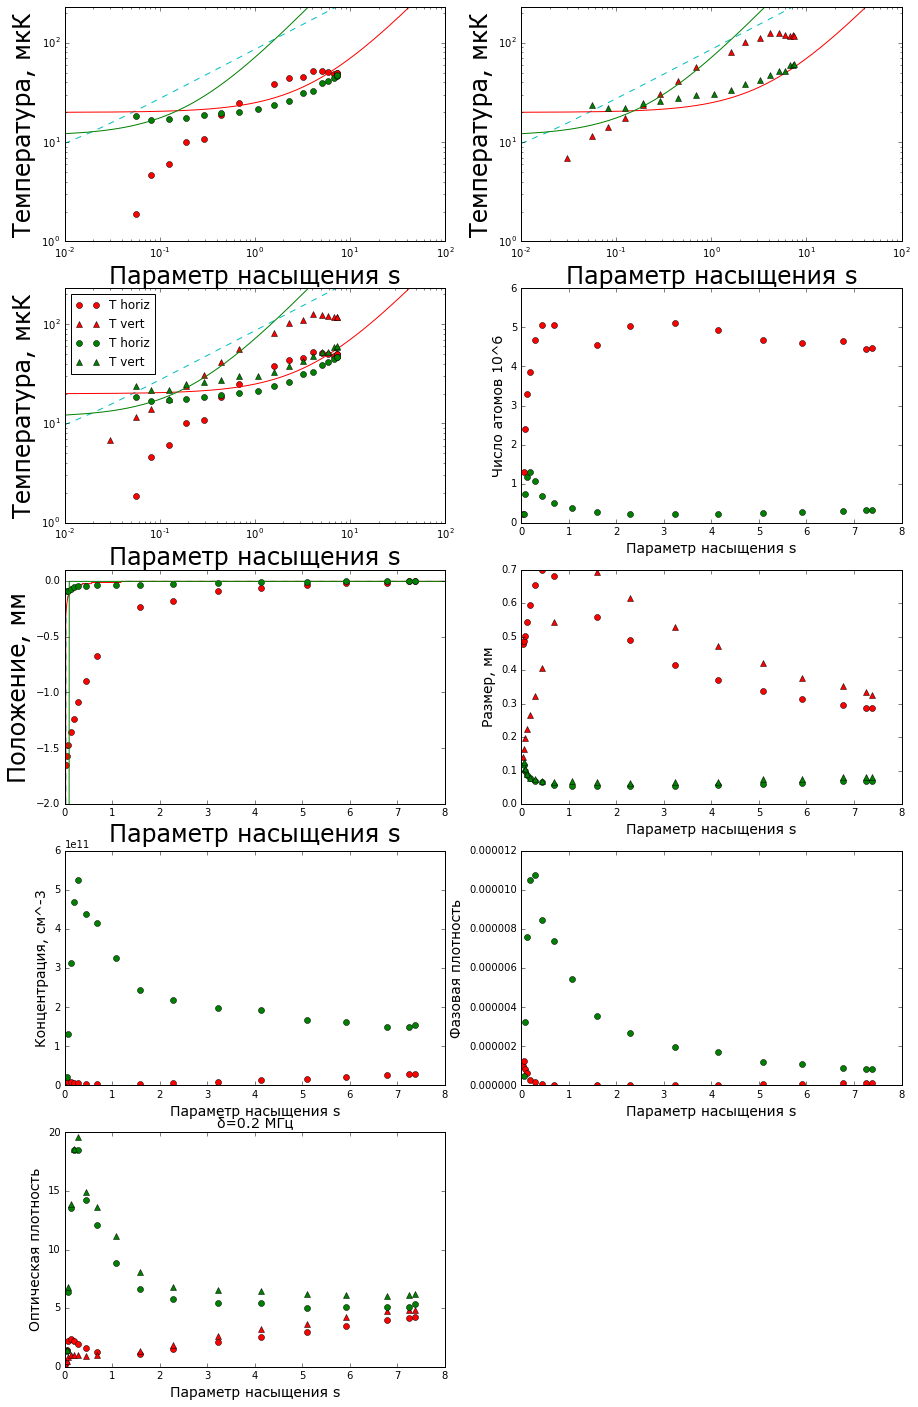

In [60]:
# от мощности
drawing_theory(tmp, 2.4, 'A', 1, 2, ['c--'])

tmp, x_lbl = vs_P_2016_05_05

drawing(tmp, x_lbl, 1, 'δ=2,4 МГц', ['ro', 'r^', 'ro'])#f=363.5
drawing_theory(tmp, 2.4, 'A', 1, 1, ['r-'])

tmp, x_lbl = vs_P_2016_05_27

#drawing(tmp, x_lbl, 1, 'δ=1 МГц', ['bo', 'b^', 'bo'])#f=364.2
#drawing_theory(tmp, 1.0, 'A', 1, 1, ['b-'])

tmp, x_lbl = vs_P_2016_05_27_small_detuning

drawing(tmp, x_lbl, 1, 'δ=0.2 МГц', ['go', 'g^', 'go'])#f=364.6
drawing_theory(tmp, 0.2, 'A', 1, 1, ['g-'])

tmp, x_lbl = vs_P_wt_2016_05_06

#drawing_theory(tmp, 2.4, 'A', 1, 1, ['m-'])
#drawing(tmp, x_lbl, 1, 'δ=2,4 МГц', ['mo', 'm^', 'mo'])#f=363.5

subplot(20,2,1)
gca().set_xscale('log')
gca().set_yscale('log')
axis([0.01,100,1,230])

subplot(20,2,2)
gca().set_xscale('log')
gca().set_yscale('log')
axis([0.01,100,1,230])

subplot(20,2,3)
gca().set_xscale('log')
gca().set_yscale('log')
axis([0.01,100,1,230])
legend(loc=2)

subplot(20,2,5)
axis([0,8,-2,0.1])

old=0
if old==1:
    Exper_s_old = [17,30,30,35,52]
    Exper_T_old = [75,26,40,110,160]
    Exper_s_2014_11 = [0.2,0.4,1.4,3,5]
    Exper_T_2014_11 = [9,18,25,26,26.20]
    Exper_s_2015_07 = [0.13,0.2,0.32,0.47]
    Exper_Tx_2015_07 = [4.9,8.1,8.9,11.9]
    # это горизонтальные Т
    Exper_Ty_2015_07 = [14.2,15.5,17.6,20.6]
    # это все для отстройки 2 МГц
    Exper_Na_2015_07 = [0.13,0.4,0.6,0.9]
    
    subplot(20,2,1)
    plot(Exper_s_old,Exper_T_old,'yo')
    plot(Exper_s_2014_11,Exper_T_2014_11,'co')
    plot(Exper_s_2015_07,Exper_Tx_2015_07,'mo')
    subplot(20,2,2)
    plot(Exper_s_2015_07,Exper_Ty_2015_07,'m^')

    subplot(20,2,3)
    plot(Exper_s_2015_07,Exper_Na_2015_07,'mo')


# Итоговый график от отстройки

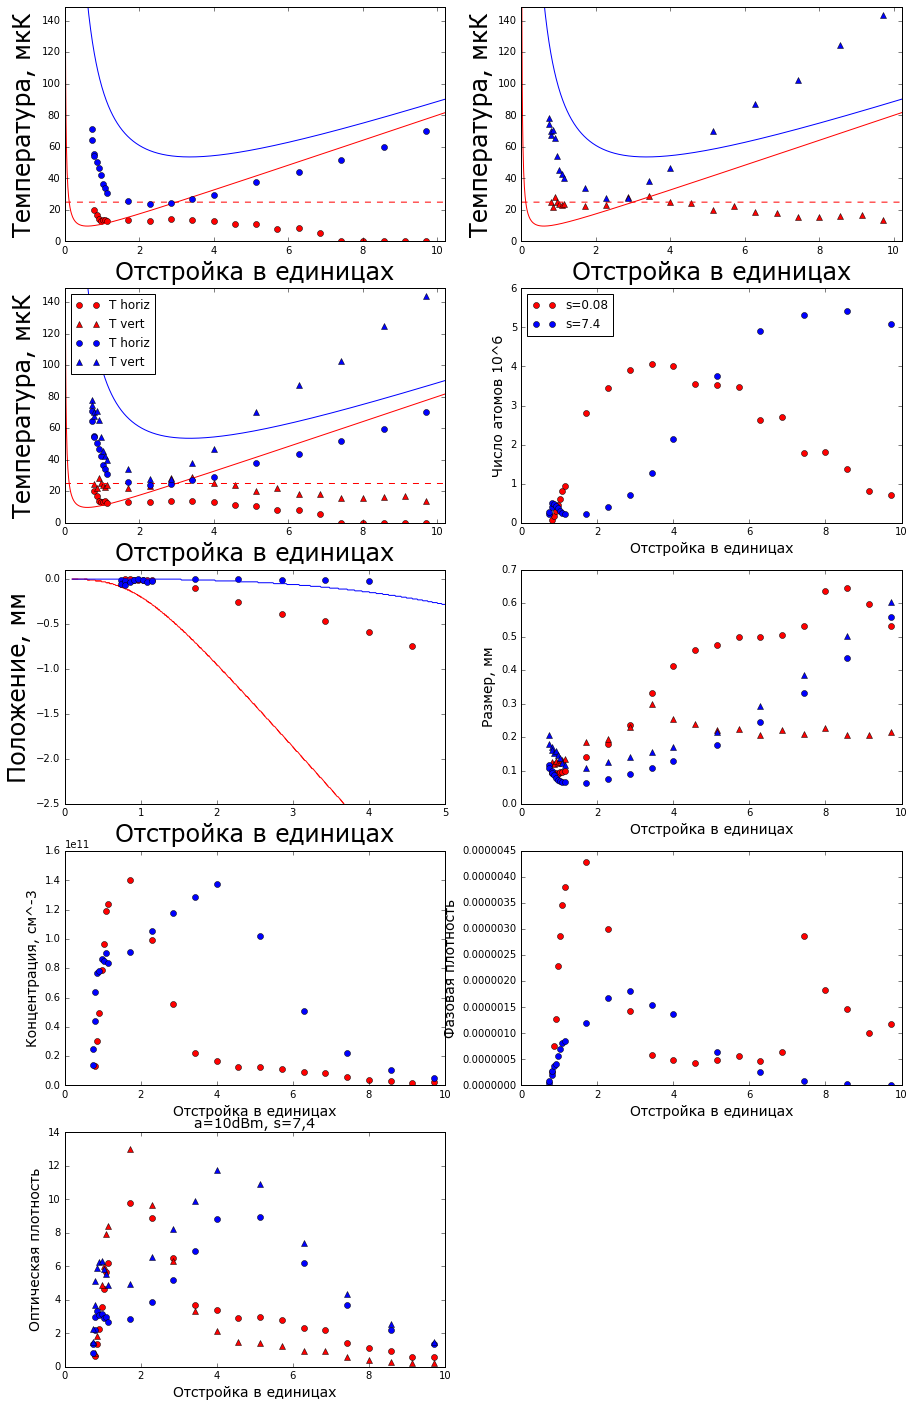

In [59]:
# от отстройки

tmp, x_lbl = vs_D_2016_05_08 #vs_D_5wt_2016_05_12#

drawing(tmp, x_lbl, 1, 'a=-5dBm, s=0,08', ['ro', 'r^', 'ro'])
s = powers[-5]*1.38/320
drawing_theory(tmp, s, 'F', 1, 2, ['r--'])
drawing_theory(tmp, s, 'F', 1, 1, ['r-'])


tmp, x_lbl = vs_D_2016_05_07

drawing(tmp, x_lbl, 1, 'a=10dBm, s=7,4', ['bo', 'b^', 'bo'])
s = powers[10]*1.38/320
drawing_theory(tmp, s, 'F', 1, 1, ['b-'])

subplot(20,2,5)
axis([0,5,-2.5,0.1])

subplot(20,2,3)
legend(loc=2)

subplot(20,2,4)
legend(['s=0.08','s=7.4'],loc=2)

# Итоговые графики для диссертации

7.978125


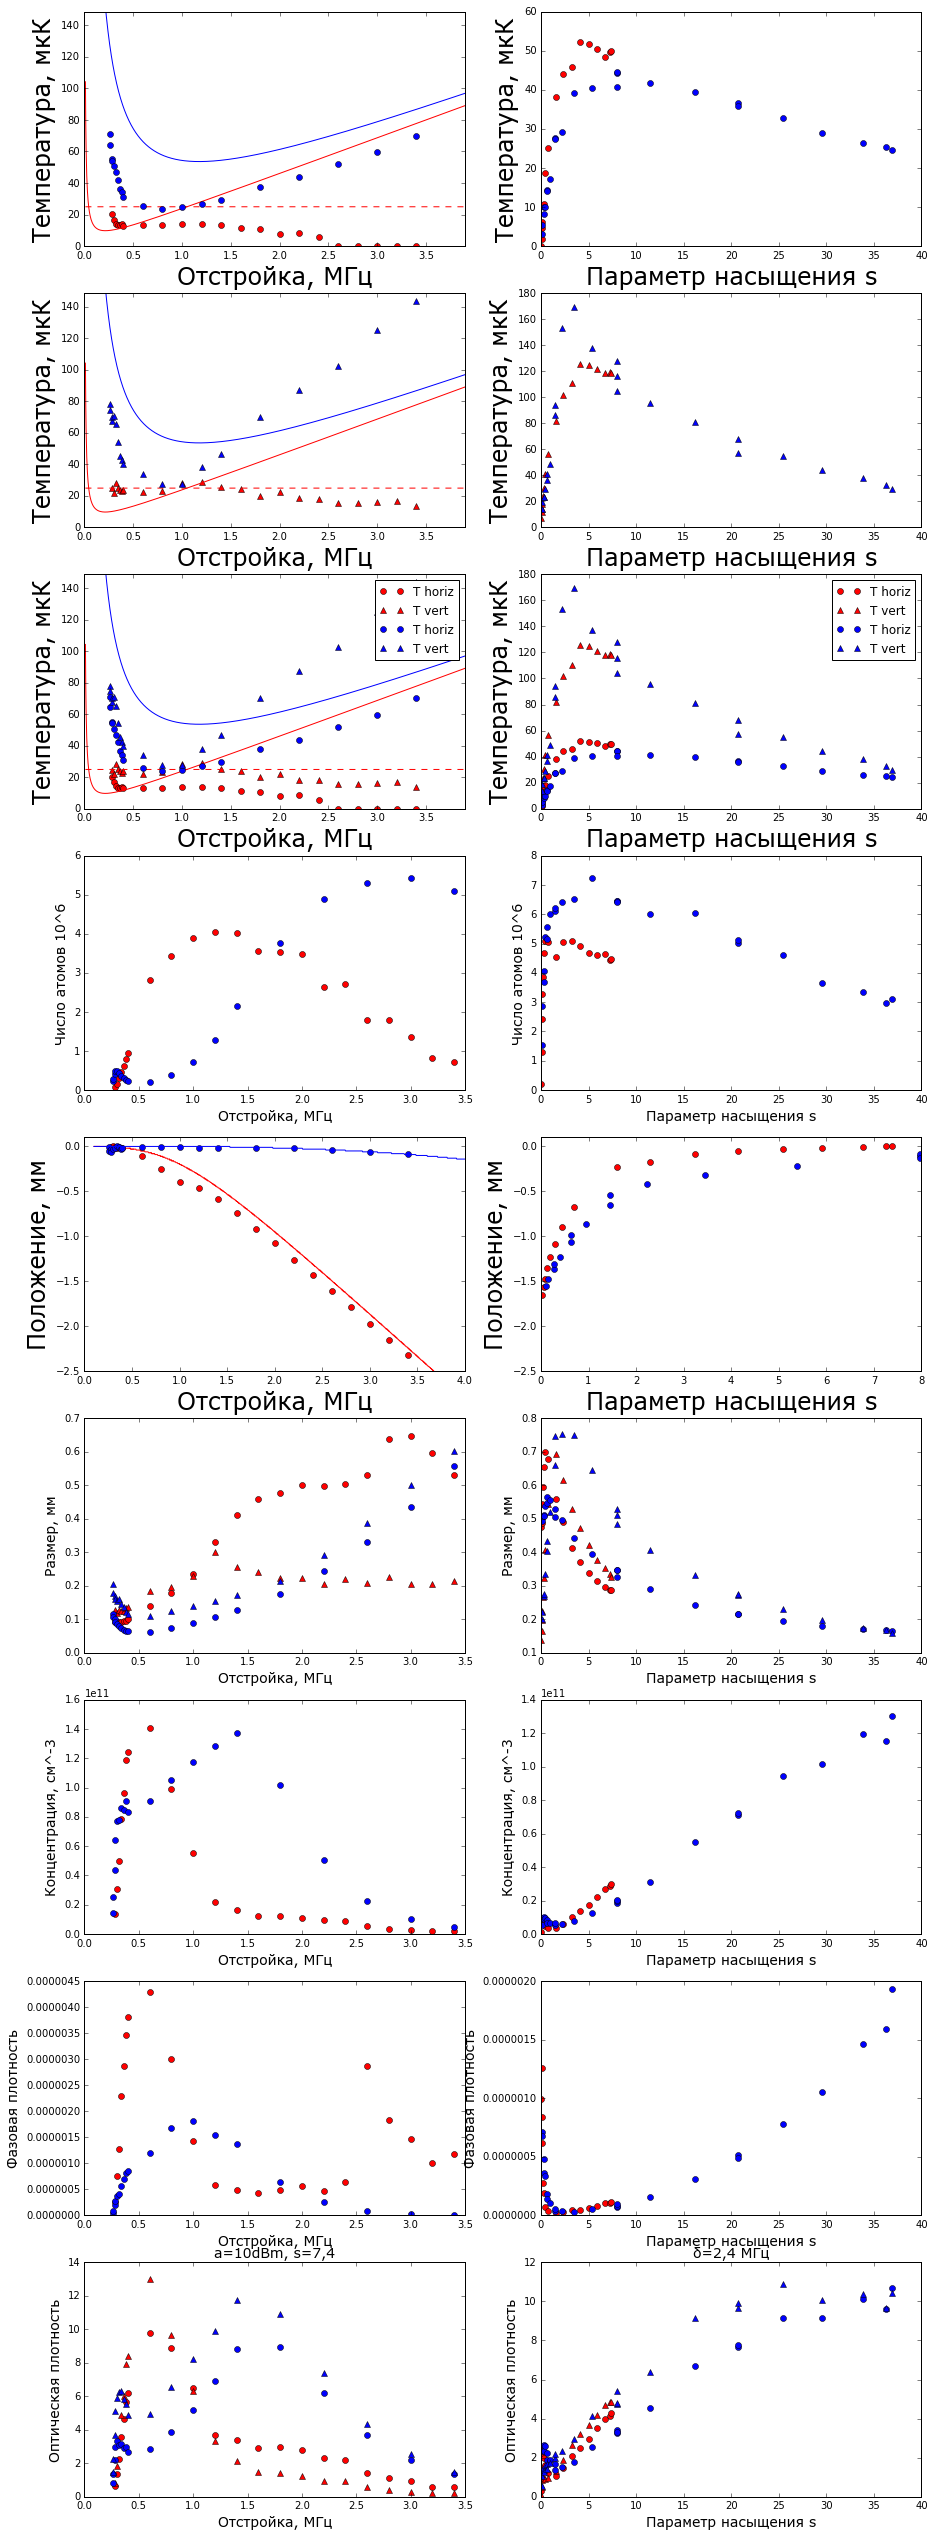

In [41]:
columns = 2
# от отстройки

tmp, x_lbl = vs_D_2016_05_08

drawing(tmp, x_lbl, 1, 'a=-5dBm, s=0,08', ['ro', 'r^', 'ro'], columns)
s = powers[-5]*1.38/320
drawing_theory(tmp, s, 'F', 1, 2, ['r--'], columns)
drawing_theory(tmp, s, 'F', 1, 1, ['r-'], columns)

tmp, x_lbl = vs_D_2016_05_07

drawing(tmp, x_lbl, 1, 'a=10dBm, s=7,4', ['bo', 'b^', 'bo'], columns)
s = powers[10]*1.38/320
drawing_theory(tmp, s, 'F', 1, 1, ['b-'], columns)

# от мощности

#drawing_theory(tmp, 2.4, 'A', 2, 2, ['c-'], columns)

tmp, x_lbl = vs_P_2016_05_05

drawing(tmp, x_lbl, 2, 'δ=2,4 МГц', ['ro', 'r^', 'ro'], columns)#f=363.5
#drawing_theory(tmp, 2.4, 'A', 2, 1, ['r-'], columns)

tmp, x_lbl = vs_P_2016_05_27

#drawing(tmp, x_lbl, 2, 'δ=1 МГц', ['bo', 'b^', 'bo'], columns)#f=364.2
#drawing_theory(tmp, 1.0, 'A', 2, 1, ['b-'], columns)

tmp, x_lbl = vs_P_2016_05_27_small_detuning

#drawing(tmp, x_lbl, 2, 'δ=0.2 МГц', ['go', 'g^', 'go'], columns)#f=364.6
#drawing_theory(tmp, 0.2, 'A', 2, 1, ['g-'], columns)

tmp, x_lbl = vs_P_wt_2016_05_06

#drawing_theory(tmp, 2.4, 'A', 2, 1, ['m-'], columns)
drawing(tmp, x_lbl, 2, 'δ=2,4 МГц', ['bo', 'b^', 'bo'], columns)#f=363.5

subplot(20,2,9)
axis([0,4,-2.5,0.1])
subplot(20,2,10)
axis([0,8,-2.5,0.1])


subplot(20,2,2)
#gca().set_xscale('log')
#gca().set_yscale('log')
#axis([0.01,100,1,230])

subplot(20,2,4)
#gca().set_xscale('log')
#gca().set_yscale('log')
#axis([0.01,100,1,230])

subplot(20,2,6)
#gca().set_xscale('log')
#gca().set_yscale('log')
#axis([0.01,100,1,230])
#legend(loc=2)

#subplot(20,2,5)
#axis([0,5,-2.5,0.1])

#subplot(20,2,3)
#legend(loc=2)

#subplot(20,2,4)
#legend(['s=0.08','s=7.4'],loc=2)

print(5*powers[2]*1.38/320)

(0, 1000.0)

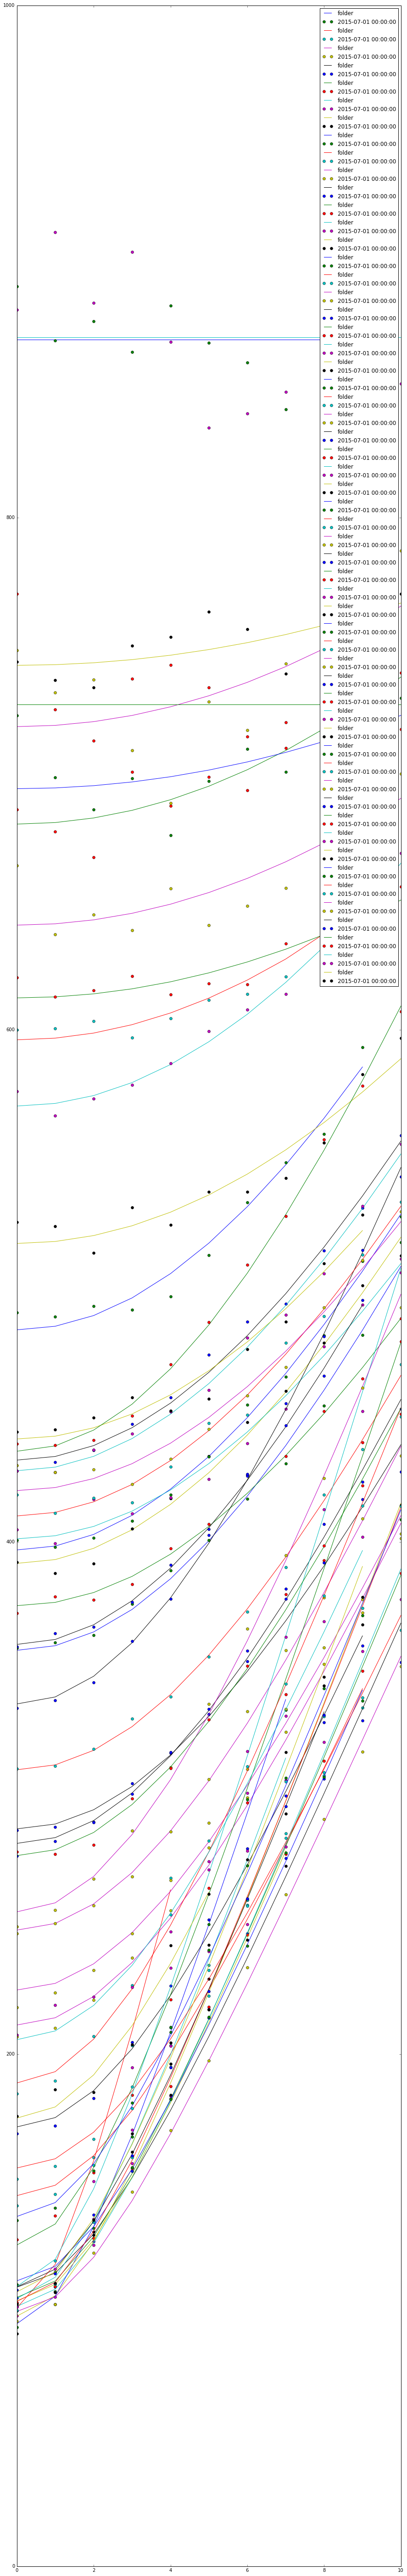

In [25]:
# Шаблон
xx = []
yy = []
for d in data:
    tbl = d['avr_table']
    x = tbl.folder
    y = tbl.fit1D_x.sigma
    ff = d['fits'][0]
    fit_func = usfuncs.cloud_expansion0
    plot(x,fit_func(x,*ff[1]))
    plot(x,y,'o',label=d['date_meas'])
legend()
ylim(bottom=0)

In [26]:
os.chdir(r'/Users/artemgolovizin/Downloads/2015_12_01')

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '/Users/artemgolovizin/Downloads/2015_12_01'

In [ ]:
old_ks = dict()

In [ ]:
with open('all_data.txt', 'rb') as handle:
    data = pickle.loads(handle.read())

In [ ]:
data.keys()

In [ ]:
data['01 t']

In [ ]:
with open('all_data.txt', 'rb') as handle:
    data = pickle.loads(handle.read())
shot_typeN = 1
ks = list(data.keys())
ks.sort()
ch_boxes = dict()
ks_n = []
for k in ks:
    # optional - uncomment line below to sift only keys with specific marker, as 'CL'
#    if 'CL' not in k.upper(): continue
    ch_boxes[k]=old_ks.get(k,True)
    ks_n.append(k)
ks = ks_n
fg = None   
def plot_gr(l_pos,**ar):
    fig,ax = subplots() 
    global fg, old_ks
    old_ks = dict()
    for k in ks:
        old_ks[k]=ar[k]
        if ar[k]:
            d1 = impr.get_avr_data(data[k]['data'], shot_typeN, 'fit1D_x',2)
            errorbar(**d1)
#             d1['fmt']='ro'
#             d1['label']='fit1D_x'
#             val=datat[k]
#             x,y=impr.data2_sort(val[0],val[1])
#             # here it's time to modify data
# #             x = mod_from_AOM_to_real_freq(x, k, 420)
#             #x,y = x[1:],y[1:]
#             ax.plot(x,y,'-*',label=k)
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
    #xscale('log')
    #xlabel('Current, A')
    #xlabel('AOM frequency, MHz')
    xlabel('detuning, MHz') #in real frequencyes
    ylabel('atoms number, a.u.')
    ylim(bottom=0)
    #start, end = ax.get_xlim()
    #print(ax.get_xlim())
    #ax.xaxis.set_ticks(arange(start, end, 0.1))
    #axvline(x=l_pos)
    fg = fig
    
ter = interactive(plot_gr,l_pos=(150,250,0.1),**ch_boxes)
ter.box_style='info'
display(ter)

In [ ]:
help(interactive)

###For managing clock line shift and broadening

#### Построение списка сканирования

In [ ]:
res = array(range(-7,7, 1))/10 + 420.1
rr = ''
for x in res:
    rr += str(x) + ' '
print(rr)